# XGBoost Model

## Data manipulation

In [ ]:
# Load in data
import pandas as pd
final_merged_df = pd.read_csv('../data/final_merged_data.csv', parse_dates=['Local Time'])

# Print preliminary data
print(f"Loaded {len(final_merged_df):,} records")
print(f"Number of unique rides: {final_merged_df['Ride'].nunique()}")

# Print a list of all unique ride names along with the number of records for each ride.
# Using value_counts() which is more reliable than manual counting
print(f"\nUnique rides:")
ride_counts = final_merged_df['Ride'].value_counts().sort_index()
for ride, count in ride_counts.items():
    print(f"  {ride}: {count:,} records")

/var/folders/pp/vwp6cpmd6xd962fpyb8gjv5w0000gn/T/ipykernel_64385/2845187436.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  final_merged_df = pd.read_csv('../data/final_merged_data.csv', parse_dates=['Local Time'])


Loaded 589,985 records
Number of unique rides: 42

Unique rides:
  Animation Academy: 18,021 records
  Games of Pixar Pier: 16,166 records
  Golden Zephyr: 18,021 records
  Goofy's Sky School: 18,021 records
  Grizzly River Run: 18,021 records
  Guardians of the Galaxy - Mission: BREAKOUT!: 18,021 records
  Guardians of the Galaxy - Monsters After Dark: 9,754 records
  Incredicoaster: 18,021 records
  Incredicoaster Single Rider: 18,021 records
  Inside Out Emotional Whirlwind: 18,021 records
  Jessie's Critter Carousel: 18,021 records
  Jumpin' Jellyfish: 18,021 records
  Luigi's Honkin' Haul-O-Ween: 1,516 records
  Luigi's Joy to the Whirl: 3,087 records
  Luigi's Rollickin' Roadsters: 11,564 records
  Mater's Graveyard JamBOOree: 3,344 records
  Mater's Jingle Jamboree: 3,087 records
  Mater's Junkyard Jamboree: 11,590 records
  Mickey's PhilharMagic: 18,021 records
  Monsters, Inc. Mike & Sulley to the Rescue!: 18,021 records
  Pixar Pal-A-Round - Swinging: 18,021 records
  Pixar P

In [ ]:
# Dropping rides that are redundant/stupid
rides_to_drop = [
    'Animation Academy',
    'Games of Pixar Pier',
    'Guardians of the Galaxy - Monsters After Dark',
    'Luigi\'s Honkin\' Haul-O-Ween',
    'Luigi\'s Joy to the Whirl',
    'Mater\'s Graveyard JamBOOree',
    'Mater\'s Jingle Jamboree',
    'Red Car Trolley',
    'Redwood Creek Challenge Trail',
    'The Bakery Tour',
    'Sorcerer\'s Workshop',
    'Soarin\' Over California',
    'Rogers: The Musical', 
    'Walt Disney Imagineering Blue Sky Cellar', 
    'Turtle Talk with Crush', 
    'Mickey\'s PhilharMagic',
    'World of Color – ONE',
    'World of Color - Season of Light',
    'Villains Grove at Oogie Boogie Bash',
    'Silly Symphony Swings Single Rider',
    'Incredicoaster Single Rider',
    'Radiator Springs Racers Single Rider'
]

print(f"Rides before filtering: {final_merged_df['Ride'].nunique()}")
print(f"Total records before filtering: {len(final_merged_df):,}")

# Filter out the specified rides
final_merged_df = final_merged_df[~final_merged_df['Ride'].isin(rides_to_drop)]

print(f"Rides after filtering: {final_merged_df['Ride'].nunique()}")
print(f"Total records after filtering: {len(final_merged_df):,}")

print(f"\nDropped rides:")
for ride in rides_to_drop:
    print(f"  - {ride}")

Rides before filtering: 42
Total records before filtering: 589,985
Rides after filtering: 20
Total records after filtering: 344,631

Dropped rides:
  - Animation Academy
  - Games of Pixar Pier
  - Guardians of the Galaxy - Monsters After Dark
  - Luigi's Honkin' Haul-O-Ween
  - Luigi's Joy to the Whirl
  - Mater's Graveyard JamBOOree
  - Mater's Jingle Jamboree
  - Red Car Trolley
  - Redwood Creek Challenge Trail
  - The Bakery Tour
  - Sorcerer's Workshop
  - Soarin' Over California
  - Rogers: The Musical
  - Walt Disney Imagineering Blue Sky Cellar
  - Turtle Talk with Crush
  - Mickey's PhilharMagic
  - World of Color – ONE
  - World of Color - Season of Light
  - Villains Grove at Oogie Boogie Bash
  - Silly Symphony Swings Single Rider
  - Incredicoaster Single Rider
  - Radiator Springs Racers Single Rider


In [ ]:
# Split the main dataset into separate, time-sorted DataFrames for each
# ride and store them in a dictionary for easy per-ride analysis.
ride_dataframes = {}

for ride in final_merged_df['Ride'].unique():
    ride_df = final_merged_df[final_merged_df['Ride'] == ride].copy()
    ride_df = ride_df.sort_values('Local Time').reset_index(drop=True)
    ride_dataframes[ride] = ride_df

## Model

In [ ]:
# Fraction of data to use for testing
test_fraction = 0.3

# Dictionary to store train/test sets per ride
ride_splits = {}

for ride, df in ride_dataframes.items():
    # Features we want to use for ML
    # Do one-hot encoding for columns where necessary
    feature_cols = [
        'hour', 'day_of_week', 'month', 'is_weekend',
        'temperature_2m (°F)', 'apparent_temperature (°F)', 'precipitation (mm)',
        'holiday_flag', 'tier', 'Land', 'holiday_name'
    ]
    target_col = 'Wait Time'    # Target variable
    
    # Determine index to split
    split_idx = int(len(df) * (1 - test_fraction))
    
    # Train/test split
    # We split the data chronologically (earlier rows for training, later rows for testing).
    # Randomly shuffling would let the model see the future, causing leakage. 
    # Chronological splitting ensures the model is trained on past data and evaluated on truly unseen future data.

    # I used .copy() for these, I'm not sure if that's necessary
    X_train = df[feature_cols].iloc[:split_idx].copy()
    X_test = df[feature_cols].iloc[split_idx:].copy()
    
    y_train = df[target_col].iloc[:split_idx].copy()
    y_test = df[target_col].iloc[split_idx:].copy()

    # One-hot encode categorical columns
    categorical_cols = ['tier', 'Land', 'holiday_name']
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)
    
    # Align columns: ensure test set has same columns as train set
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    # Store in dictionary
    ride_splits[ride] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"{ride}: Train size = {len(X_train)}, Test size = {len(X_test)}")

Guardians of the Galaxy - Mission: BREAKOUT!: Train size = 12144, Test size = 5205
Golden Zephyr: Train size = 12144, Test size = 5205
Goofy's Sky School: Train size = 12144, Test size = 5205
Silly Symphony Swings: Train size = 12144, Test size = 5205
The Little Mermaid - Ariel's Undersea Adventure: Train size = 12144, Test size = 5205
Incredicoaster: Train size = 12144, Test size = 5205
Inside Out Emotional Whirlwind: Train size = 12144, Test size = 5205
Jessie's Critter Carousel: Train size = 12144, Test size = 5205
Jumpin' Jellyfish: Train size = 12144, Test size = 5205
Pixar Pal-A-Round - Swinging: Train size = 12144, Test size = 5205
Pixar Pal-A-Round – Non-Swinging: Train size = 12144, Test size = 5205
Toy Story Midway Mania!: Train size = 12144, Test size = 5205
WEB SLINGERS: A Spider-Man Adventure: Train size = 12144, Test size = 5205
WEB SLINGERS: A Spider-Man Adventure Single Rider: Train size = 12144, Test size = 5205
Luigi's Rollickin' Roadsters: Train size = 7624, Test siz

In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.0.1


In [ ]:
# Train XGBoost Models for Each Ride and Evaluate MAE

import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Dictionary to store trained models and MAE
ride_models = {}
ride_mae = {}

for ride, data in ride_splits.items():
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    # Initialize XGBoost regressor
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Save model and MAE
    ride_models[ride] = xgb_model
    ride_mae[ride] = mae
    
# Determine the maximum length of ride names for formatting
max_ride_length = max(len(ride) for ride in ride_splits.keys())

# Print header
header = f"{'Ride':<{max_ride_length}} | Seasonal Naive MAE | XGBoost MAE"
print(header)
print("-" * len(header))

# Print results
for ride in ride_splits.keys():
    naive_mae = baseline_results.get(ride, float('nan'))
    xgb_mae = ride_mae.get(ride, float('nan'))
    print(f"{ride:<{max_ride_length}} | {naive_mae:>17.2f} | {xgb_mae:>11.2f}")

Ride                                              | Seasonal Naive MAE | XGBoost MAE
------------------------------------------------------------------------------------
Guardians of the Galaxy - Mission: BREAKOUT!      |             33.87 |       25.46
Golden Zephyr                                     |              6.26 |        5.64
Goofy's Sky School                                |             23.17 |       15.15
Silly Symphony Swings                             |              7.14 |        5.82
The Little Mermaid - Ariel's Undersea Adventure   |             14.35 |       10.24
Incredicoaster                                    |             22.38 |       15.55
Inside Out Emotional Whirlwind                    |             12.62 |        8.20
Jessie's Critter Carousel                         |              2.30 |        2.17
Jumpin' Jellyfish                                 |              7.02 |        6.54
Pixar Pal-A-Round - Swinging                      |             19.78 |   

In [ ]:
# Cross-Validation and Hyperparameter Tuning for XGBoost Models

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use TimeSeriesSplit for proper time series cross-validation
# This ensures we don't use future data to predict past data
tscv = TimeSeriesSplit(n_splits=5)

# Clear any previous results and create fresh dictionaries
best_ride_models = {}
best_ride_params = {}
best_ride_mae_cv = {}

print("Starting cross-validation for each ride...")
print("This may take a few minutes...")
print()

# Get list of rides for consistent ordering
rides_list = list(ride_splits.keys())
total_rides = len(rides_list)

for i, ride in enumerate(rides_list, 1):
    print(f"Processing ride {i}/{total_rides}: {ride}")
    
    # Get data for this specific ride
    ride_data = ride_splits[ride]
    X_train_ride = ride_data['X_train'].copy()
    y_train_ride = ride_data['y_train'].copy()
    X_test_ride = ride_data['X_test'].copy()
    y_test_ride = ride_data['y_test'].copy()
    
    # Create a fresh XGBoost model for this ride
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Perform grid search with time series cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the grid search using the correct ride-specific data
    grid_search.fit(X_train_ride, y_train_ride)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = -grid_search.best_score_  # Convert back from negative
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_ride)
    test_mae = mean_absolute_error(y_test_ride, y_pred)
    
    # Store results
    best_ride_models[ride] = best_model
    best_ride_params[ride] = best_params
    best_ride_mae_cv[ride] = {
        'cv_mae': best_cv_score,
        'test_mae': test_mae
    }
    
    print(f"  Best CV MAE: {best_cv_score:.2f}")
    print(f"  Test MAE: {test_mae:.2f}")
    print(f"  Best params: {best_params}")
    print()

print("Cross-validation completed!")

Starting cross-validation for each ride...
This may take a few minutes...

Processing ride 1/20: Guardians of the Galaxy - Mission: BREAKOUT!
  Best CV MAE: 24.75
  Test MAE: 24.62
  Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Processing ride 2/20: Golden Zephyr
  Best CV MAE: 3.66
  Test MAE: 5.47
  Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Processing ride 3/20: Goofy's Sky School
  Best CV MAE: 13.14
  Test MAE: 15.30
  Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.9}

Processing ride 4/20: Silly Symphony Swings
  Best CV MAE: 4.26
  Test MAE: 5.74
  Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

Processing ride 5/20: The Little Mermaid - Ariel's Undersea Adventure
  Best CV MAE: 9.61
  Test MAE: 9.89
  

In [ ]:
# Display Comprehensive Results: Seasonal Naive vs Basic XGBoost vs Tuned XGBoost

# Calculate improvements
print("=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print()

# Determine the maximum length of ride names for formatting
max_ride_length = max(len(ride) for ride in ride_splits.keys())

# Print header
header = f"{'Ride':<{max_ride_length}} | {'Seasonal Naive':>15} | {'Basic XGBoost':>13} | {'Tuned XGBoost':>13} | {'CV MAE':>7} | {'Improvement':>11}"
print(header)
print("-" * len(header))

total_improvement_basic = 0
total_improvement_tuned = 0
ride_count = len(ride_splits)

# Print results for each ride
for ride in sorted(ride_splits.keys()):
    naive_mae = baseline_results.get(ride, float('nan'))
    basic_xgb_mae = ride_mae.get(ride, float('nan'))
    tuned_cv_mae = best_ride_mae_cv.get(ride, {}).get('cv_mae', float('nan'))
    tuned_test_mae = best_ride_mae_cv.get(ride, {}).get('test_mae', float('nan'))
    
    # Calculate improvement percentages
    if not np.isnan(naive_mae) and not np.isnan(tuned_test_mae) and naive_mae > 0:
        improvement = ((naive_mae - tuned_test_mae) / naive_mae) * 100
        total_improvement_tuned += improvement
    else:
        improvement = 0
        
    if not np.isnan(naive_mae) and not np.isnan(basic_xgb_mae) and naive_mae > 0:
        basic_improvement = ((naive_mae - basic_xgb_mae) / naive_mae) * 100
        total_improvement_basic += basic_improvement
    else:
        basic_improvement = 0
    
    print(f"{ride:<{max_ride_length}} | {naive_mae:>15.2f} | {basic_xgb_mae:>13.2f} | {tuned_test_mae:>13.2f} | {tuned_cv_mae:>7.2f} | {improvement:>10.1f}%")

print("-" * len(header))
print(f"{'AVERAGE IMPROVEMENT':<{max_ride_length}} | {'':<15} | {total_improvement_basic/ride_count:>12.1f}% | {total_improvement_tuned/ride_count:>12.1f}% | {'':<7} | {'':<11}")
print()

# Display best hyperparameters for each ride
print("BEST HYPERPARAMETERS FOR EACH RIDE:")
print("=" * 50)
for ride, params in best_ride_params.items():
    print(f"\n{ride}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

# Summary statistics
print("\nSUMMARY STATISTICS:")
print("=" * 30)
tuned_maes = [result['test_mae'] for result in best_ride_mae_cv.values()]
print(f"Average Tuned XGBoost MAE: {np.mean(tuned_maes):.2f} ± {np.std(tuned_maes):.2f}")
print(f"Average improvement from Seasonal Naive to Tuned XGBoost: {total_improvement_tuned/ride_count:.1f}%")
print(f"Best performing ride: {min(best_ride_mae_cv.keys(), key=lambda k: best_ride_mae_cv[k]['test_mae'])}")
print(f"Worst performing ride: {max(best_ride_mae_cv.keys(), key=lambda k: best_ride_mae_cv[k]['test_mae'])}")

COMPREHENSIVE MODEL COMPARISON

Ride                                              |  Seasonal Naive | Basic XGBoost | Tuned XGBoost |  CV MAE | Improvement
---------------------------------------------------------------------------------------------------------------------------
Golden Zephyr                                     |            6.26 |          5.64 |          5.47 |    3.66 |       12.6%
Goofy's Sky School                                |           23.17 |         15.15 |         15.30 |   13.14 |       33.9%
Grizzly River Run                                 |           15.47 |         13.88 |         13.81 |    7.90 |       10.7%
Guardians of the Galaxy - Mission: BREAKOUT!      |           33.87 |         25.46 |         24.62 |   24.75 |       27.3%
Incredicoaster                                    |           22.38 |         15.55 |         15.35 |   13.84 |       31.4%
Inside Out Emotional Whirlwind                    |           12.62 |          8.20 |          7.74 

FEATURE IMPORTANCE ANALYSIS

Top 10 features for Guardians of the Galaxy - Mission: BREAKOUT!:
   1. month                          0.3068
   2. hour                           0.1348
   3. tier_4                         0.0534
   4. temperature_2m (°F)            0.0529
   5. tier_2                         0.0507
   6. tier_0                         0.0489
   7. tier_3                         0.0460
   8. apparent_temperature (°F)      0.0455
   9. day_of_week                    0.0386
  10. tier_1                         0.0378

Top 10 features for Golden Zephyr:
   1. tier_6                         0.2243
   2. temperature_2m (°F)            0.1277
   3. holiday_name_Washington's Birthday 0.1248
   4. hour                           0.1221
   5. apparent_temperature (°F)      0.1113
   6. month                          0.1104
   7. holiday_name_Christmas Day     0.0816
   8. day_of_week                    0.0805
   9. tier_0                         0.0099
  10. tier_3                 

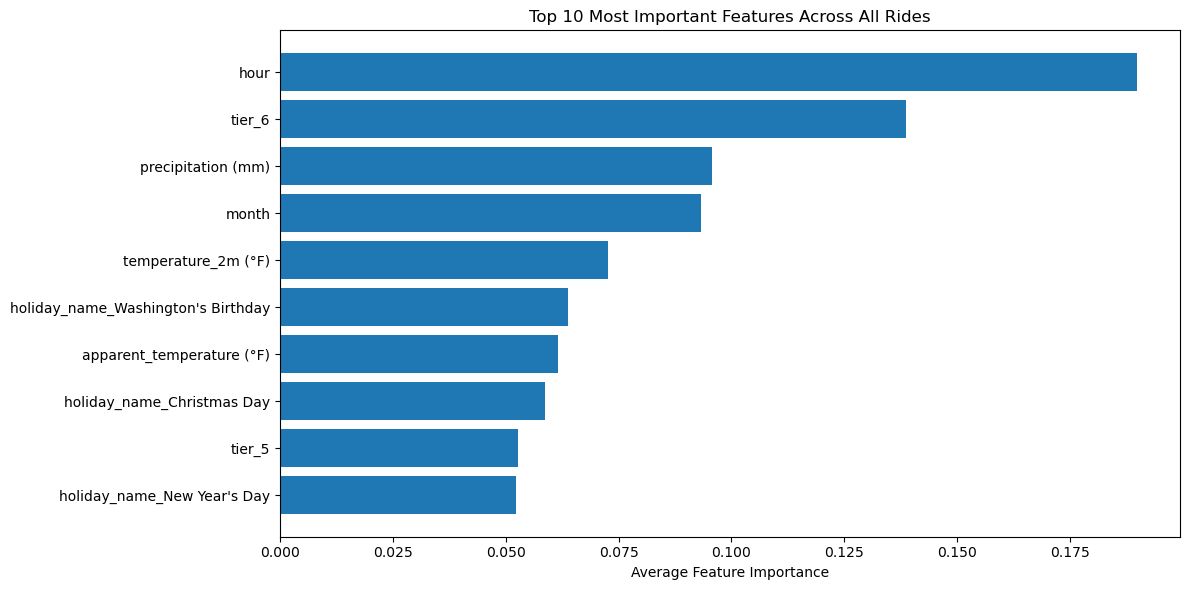


Note: Feature importance is calculated using XGBoost's built-in feature importance,
which measures the average gain of splits using each feature across all trees.


In [ ]:
# Feature Importance Analysis from Best Models

import matplotlib.pyplot as plt

print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 40)

# Calculate average feature importance across all rides
feature_importance_sum = {}
feature_count = {}

for ride, model in best_ride_models.items():
    # Get feature names and importances
    feature_names = ride_splits[ride]['X_train'].columns
    importances = model.feature_importances_
    
    print(f"\nTop 10 features for {ride}:")
    # Sort features by importance
    feature_importance_pairs = list(zip(feature_names, importances))
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(feature_importance_pairs[:10]):
        print(f"  {i+1:2d}. {feature:<30} {importance:.4f}")
        
        # Add to global sum for averaging
        if feature in feature_importance_sum:
            feature_importance_sum[feature] += importance
            feature_count[feature] += 1
        else:
            feature_importance_sum[feature] = importance
            feature_count[feature] = 1

# Calculate average importance across all rides
avg_feature_importance = {feature: feature_importance_sum[feature] / feature_count[feature] 
                         for feature in feature_importance_sum}

# Sort by average importance
sorted_avg_features = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\n\nAVERAGE FEATURE IMPORTANCE ACROSS ALL RIDES:")
print("=" * 50)
for i, (feature, avg_importance) in enumerate(sorted_avg_features[:15]):
    print(f"{i+1:2d}. {feature:<35} {avg_importance:.4f}")

# Create a visualization of top features
top_features = sorted_avg_features[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(12, 6))
plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Average Feature Importance')
plt.title('Top 10 Most Important Features Across All Rides')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nNote: Feature importance is calculated using XGBoost's built-in feature importance,")
print(f"which measures the average gain of splits using each feature across all trees.")